In [1]:
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as np
import math

import matplotlib.pyplot as plt

### Data Generation

In [2]:
np.random.seed(32)

In [3]:
### Data of g function distribution
### Cos함수와 관련된 데이터를 만드는 함수

# cos(alpha_0*x_0 + alpha_1*x_1 + ... + alpha_n*x_n)
def Cos(samples, alpha, xmin, xmax):
    """
    Generate datas we will use for the Model
    cos(alpha_0*x_0 + alpha_1*x_1 + ... + alpha_n*x_n)

    INPUT
    samples(int) : number of datas
    coefficients(array)\vec{\aplpha}] : coefficients for the x_i
    dim(int)[\vec{x}] : dimension of x data
    xmax : max value of each x_i
    xmin : min value of each x_i

    OUTPUT
    data sets(\vec{x}, cos(\vec{\alpha} \dot \vec{x}))
    """
    points= []
    results = []
    dim = len(alpha)

    def f(alpha, point):
        if len(alpha) != len(point):
            ValueError("dimension of alpha and x is not same")
    
        a = np.dot(alpha, point)
        return a

    # Mading sample points
    for i in range(samples):
        
        point = []
        for j in range(dim):
            x = np.random.uniform(xmin[j], xmax[j])
            point.append(x)


        result = np.cos(f(alpha, point))

        points.append(point)
        results.append(result)

    return np.array(points, requires_grad = False), np.array(results, requires_grad = False)


# ------------------------------------------------------------------ #
xmin = [0, 0, 0]
xmax=[np.pi, np.pi, np.pi]
Xdata, ydata = Cos(10, [1, 2, 1/2], xmin , xmax)
print(Xdata.shape)
print(ydata)
print(Xdata[:,0])

(10, 3)
[ 0.93192988 -0.87187871  0.67853013 -0.98898661  0.84755023  0.9580561
 -0.1563195   0.91969869 -0.10061588 -0.19968805]
[2.69828021 3.00228359 0.3175728  1.87412789 2.08209846 2.21077799
 1.76492112 0.29188521 1.4200579  2.22855342]


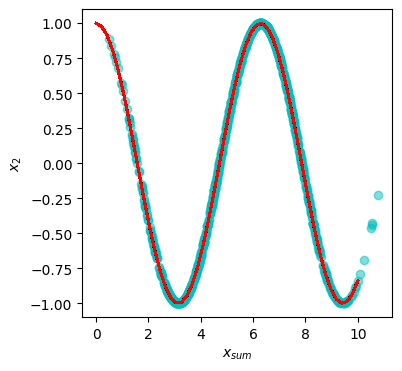

In [4]:
def plot_data(x, alpha, y, fig = None, ax = None):
    
    # Graph figure
    if fig == None :
        fig, ax = plt.subplots(1,1,figsize = (5, 5))
    
    def f(alpha, point):
        if len(alpha) != len(point):
            ValueError("dimension of alpha and x is not same")
    
        a = np.dot(alpha, point)
        return a
    
    for i in range(len(x)):
        x1 = f(alpha, x[i])
        x2 = y[i]
        s = np.linspace(0, 10)
        ax.scatter(x1, x2, alpha=0.5, color = 'c')
        ax.plot(s, np.cos(s), color = 'r')
        ax.set_xlabel("$x_{sum}$")
        ax.set_ylabel("$x_2$")

# ------------------------------------------------------------------ #

fig, ax = plt.subplots(figsize=(4, 4))
Xdata, ydata = Cos(1000, [1, 2, 1/2], xmin=[0, 0, 0], xmax = [np.pi, np.pi, np.pi])
plot_data(Xdata, [1, 2, 1/2], ydata, fig, ax)

### Variational Quantum Circuit Model

[0.89957447 0.28948926 0.22126323 0.08910268 0.93303264 0.41839298
 0.85762733 0.8050386  0.63739756 0.2775832  0.77043704 0.79194804
 0.06974757 0.44137112 0.93924518 0.83593912 0.52191194 0.17817234
 0.5569281  0.67530909 0.88576687 0.01491975 0.32765811 0.57974956
 0.60523802 0.04606377 0.14884971 0.88316109 0.81991306 0.23165686]
3
------------------------------------------------------------------
0.152316980137556
------------------------------------------------------------------


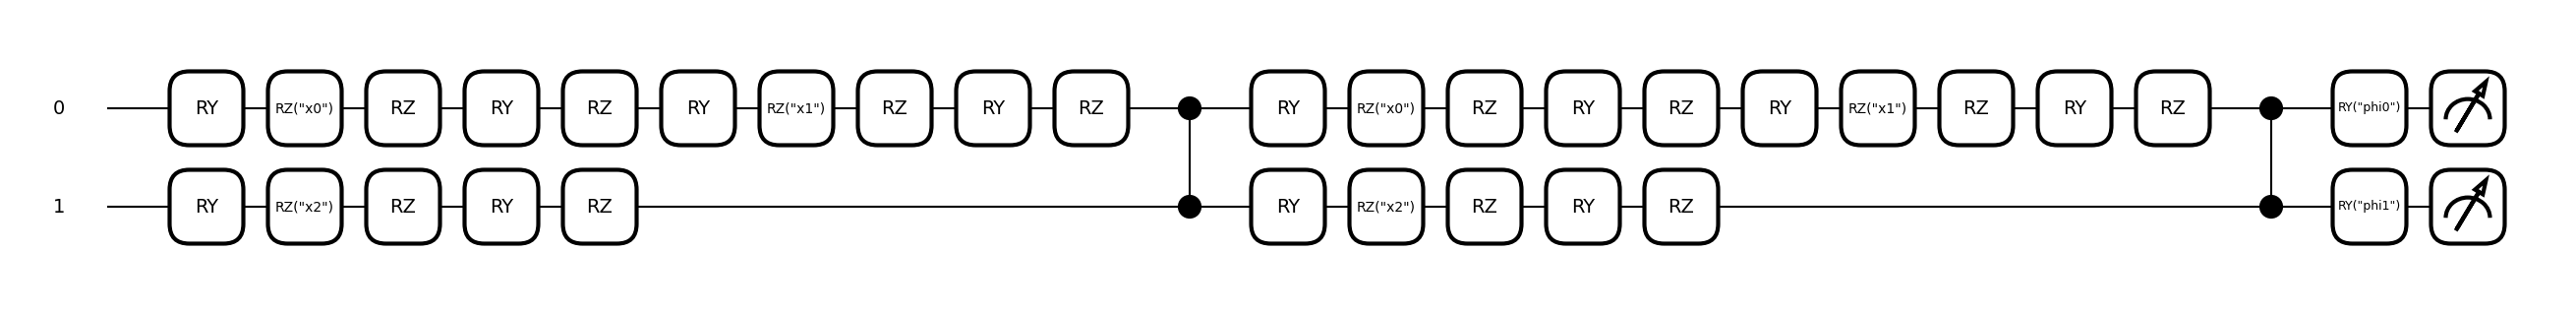

In [5]:
dev = qml.device("lightning.qubit", wires = 10)

@qml.qnode(dev)
def VQC_Model(thetas, phis, x, num_layers):
    """
    Variational Quantum Circuit model for Multi Variable Integration

    INPUT
    params : parameters for the circuit we will train them
    phis : array of parameters applied to the last RY gate
    x(Xdata[i]) : data point we have to upload
    num_layers : layers for the circuit

    OUTPUT
    Expectation value with PauliZ measure
    """
    
    dim = len(x)
    num_qubits = math.ceil(dim / 2)
    idx = 0

    params = list(thetas).copy()
    
    for _ in range(num_layers):
        for i in range(dim):
            qubit = i // 2
            qml.RY(params[idx], wires = qubit)
            qml.RZ(params[idx+1]*x[i], wires = qubit, id = f'x{i}') # Re-uploading data here
            qml.RZ(params[idx+2], wires = qubit)
            qml.RY(params[idx+3], wires = qubit)
            qml.RZ(params[idx+4], wires = qubit)
            idx += 5

        if num_qubits > 1:
            for q in range(0,num_qubits-1,1):
                qml.CZ([q, q+1])
            if num_qubits > 2:
                qml.CZ([num_qubits-1, 0])

    if num_qubits > 1:
        for i in range(num_qubits):
           qml.RY(phis[i], wires=i, id = f"phi{i}")
    
    obs = qml.PauliZ(0)
    for i in range(num_qubits-1):
         obs = obs @ qml.PauliZ(i+1)

    return qml.expval(obs)

# ------------------------------------------------------------------ #
xmax=[np.pi, np.pi, np.pi]
xmin = [0,0,0]
Xdata, ydata = Cos(10, [1, 2, 1/2], xmin, xmax)
x = Xdata[0]
dim = len(x)
num_layers = 2
num_qubits = math.ceil(len(x) / 2)

thetas = np.random.uniform(size = dim*num_layers*5,requires_grad = True)
phis = np.random.uniform(size = num_qubits, requires_grad =True)


print(thetas)
print(len(x))
print('------------------------------------------------------------------')
print(VQC_Model(thetas, phis, x, num_layers))
print('------------------------------------------------------------------')
fig, ax = qml.draw_mpl(VQC_Model)(thetas, phis, x, num_layers)


### Cost function

In [6]:
def cost_function(thetas, phis, Xdata, num_layers, y):
    loss = 0.0

    for i in range(len(Xdata)):
        prediction = VQC_Model(thetas, phis, Xdata[i], num_layers)
        loss += (prediction - y[i])**2

    return loss / len(Xdata)

# ------------------------------------------------------------------ #

#Xdata, ydata = Cos(100, [1, 2, 1/2], 3, xmax=[np.pi, np.pi, np.pi], xmin = [0, 0, 0])
#x = Xdata[:20]
#dim = len(x)
#num_layers = 2
#num_qubits = math.ceil(len(x) / 2)

#thetas = np.random.uniform(size = dim*num_layers*5,requires_grad = True)
#phis = np.random.uniform(size = num_qubits, requires_grad =True)

#cost_function(thetas, phis, x, num_layers, ydata)


### Model Running

In [7]:
def model_running(thetas, phis, x, num_layers):
    """
    Model running with given set of data.

    INPUT


    Returns
    Predicted labels for given data, Expectation value of the circuit
    """
    
    exepctation_values = []

    for i in range(len(x)):
        expval = VQC_Model(thetas, phis, x[i], num_layers)
        exepctation_values.append(expval)
        
    return np.array(exepctation_values)

In [8]:
def accuracy(ypred, ydata):

    score = 0
    for i in range(len(ydata)):
        acc = ypred[i] / ydata[i] - 1
        if np.abs(acc) < 0.2:
            score += 1

    return score/len(ydata)

In [9]:
def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data
    
    INPUT
    inputs : input data
    targets : targets
    batch_size : size of the batch, the number of datas in one batch

    Returns
    one batch of input data of length `batch_size`, one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

-------------

In [10]:
### Preparing datas
alphas = [1, 2, 1/2]
dim = len(alphas)
xmax = [np.pi, np.pi, np.pi]
xmin = [0, 0, 0]

train_data, train_target = Cos(250, alphas, xmin, xmax)
test_data, test_target = Cos(750, alphas, xmin, xmax)

# Trainnig option settings
num_layers = 3
epochs = 100
batch_size = 50
lr = 0.03

# Using the Optimizer
opt = AdamOptimizer(lr)                 ### Adam Optimizer
#opt = GradientDescentOptimizer(lr)      ### GradientDescent based on Parmaeter Shift Rule

# Initializing random parameters for the circuit
thetas = np.random.uniform(size=dim*num_layers*5, requires_grad=True)
phis = np.random.uniform(size = num_qubits, requires_grad =True)

### Evaluating the qNN
# Running the model with test data
pred_train = model_running(thetas, phis, train_data, num_layers)
score_train = accuracy(pred_train, train_target)

# Running the model with the test data
pred_test = model_running(thetas, phis, test_data, num_layers)
score_test = accuracy(pred_test, test_target)

# Saving predictions with random weights for comparison 
initial_predictions = pred_test

loss = cost_function(thetas, phis, test_data, num_layers, test_target)

loss_list = [loss]
accuracy_train_list = [score_train]
accuracy_test_list = [score_test]

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss.item(), score_train, score_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, train_target, batch_size=batch_size):
        thetas, phis, _, _, _ = opt.step(cost_function, thetas, phis, Xbatch, num_layers, ybatch)

    pred_train = model_running(thetas, phis, train_data, num_layers)
    score_train = accuracy(pred_train, train_target)
    loss = cost_function(thetas, phis, train_data, num_layers, train_target)

    pred_test = model_running(thetas, phis, test_data, num_layers)
    score_test = accuracy(pred_test, test_target)
    res = [it + 1, loss.item(), score_train, score_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

    loss_list.append(loss)
    accuracy_train_list.append(score_train)
    accuracy_test_list.append(score_test)


Epoch:  0 | Cost: 0.374477 | Train accuracy: 0.028000 | Test Accuracy: 0.057333
Epoch:  1 | Loss: 0.264853 | Train accuracy: 0.068000 | Test accuracy: 0.089333
Epoch:  2 | Loss: 0.196839 | Train accuracy: 0.168000 | Test accuracy: 0.193333
Epoch:  3 | Loss: 0.102210 | Train accuracy: 0.192000 | Test accuracy: 0.237333
Epoch:  4 | Loss: 0.051950 | Train accuracy: 0.288000 | Test accuracy: 0.362667
Epoch:  5 | Loss: 0.025307 | Train accuracy: 0.536000 | Test accuracy: 0.546667
Epoch:  6 | Loss: 0.018696 | Train accuracy: 0.628000 | Test accuracy: 0.577333
Epoch:  7 | Loss: 0.013265 | Train accuracy: 0.760000 | Test accuracy: 0.682667
Epoch:  8 | Loss: 0.007694 | Train accuracy: 0.812000 | Test accuracy: 0.760000
Epoch:  9 | Loss: 0.005287 | Train accuracy: 0.848000 | Test accuracy: 0.810667
Epoch: 10 | Loss: 0.004950 | Train accuracy: 0.848000 | Test accuracy: 0.794667
Epoch: 11 | Loss: 0.004456 | Train accuracy: 0.832000 | Test accuracy: 0.797333
Epoch: 12 | Loss: 0.003833 | Train accur

Cost: 0.000594 | Train accuracy 0.948000 | Test Accuracy : 0.944000
Learned weights
thetas = [ 0.08847876  0.19404416 -0.17318755  0.94573256 -0.09629584  0.42661024
  0.43660698  0.37827321  0.26585749  0.18404455  1.58537841  0.75591316
  0.50628781  0.10560161  1.02550572 -0.42796559  0.21218116  0.97038666
  0.50489177  0.27945884  0.155175    0.66158199  0.23500709 -0.10417861
  0.34989417 -0.21576026  0.01093632  0.47718211 -0.56803746  0.13727485
  0.15620898  0.82598315  0.54133372 -0.2037687  -0.06997137  0.30489711
  1.01516869  0.6278894   0.1431436   0.4069546   0.78428726  0.08349488
  0.65846967  0.13728958  1.27171358]
phis = [1.47558094 0.01919301]


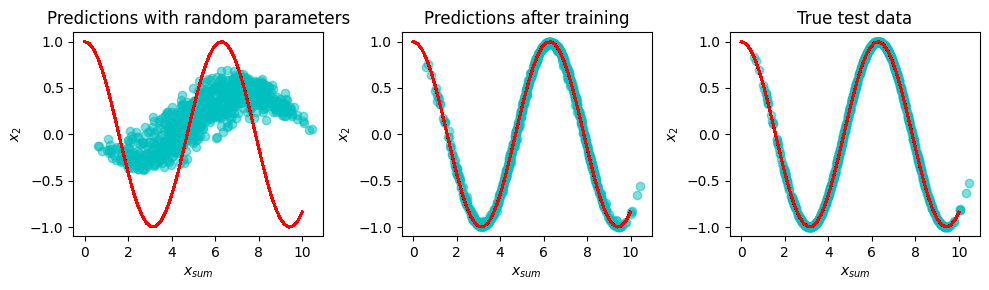

In [11]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, score_train, score_test
    )
)

print("Learned weights")
print("thetas = {}".format(thetas))
print("phis = {}".format(phis))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(test_data, alphas, initial_predictions, fig, axes[0])
plot_data(test_data, alphas, pred_test, fig, axes[1])
plot_data(test_data, alphas, test_target, fig, axes[2])

axes[0].set_title("Predictions with random parameters")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


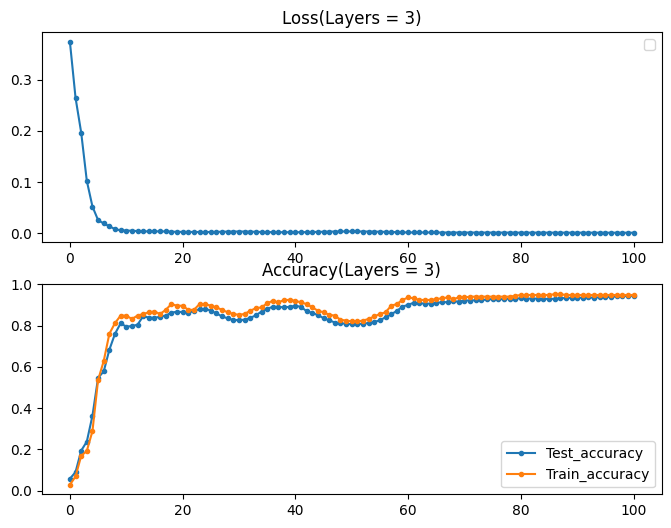

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(loss_list,'.-')
axes[1].plot(accuracy_test_list,'.-', label = 'Test_accuracy')
axes[1].plot(accuracy_train_list,'.-', label = 'Train_accuracy')
axes[0].legend()
axes[1].legend()
axes[1].set_ylim(top = 1.0)
axes[0].set_title(f"Loss(Layers = {num_layers})")
axes[1].set_title(f"Accuracy(Layers = {num_layers})")
plt.show()

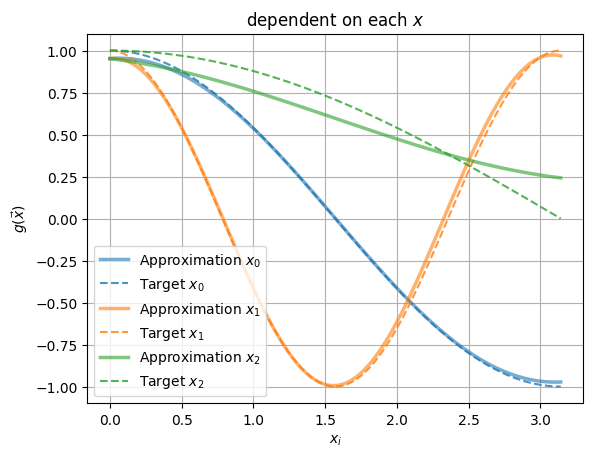

In [31]:
xlin = np.linspace(0,np.pi,100)
arr = np.zeros(100)

num_layers = 3
alphas = [1, 2, 1/2]
dim = len(alphas)

xlin_data1 = np.stack((xlin, arr, arr), axis=1)
xlin_data2 = np.stack((arr, xlin, arr), axis=1)
xlin_data3 = np.stack((arr, arr, xlin), axis=1)
integral = 0
xlin_data = np.stack((xlin_data1, xlin_data2, xlin_data3), axis=0)
for i in range(dim):
        ypred = model_running(thetas, phis, xlin_data[i], num_layers)
        ytrue = np.cos(alphas[i]*xlin)

        color = plt.rcParams["axes.prop_cycle"].by_key()["color"][i]

        plt.plot(xlin, 
                ypred,
                label=f"Approximation $x_{i}$",
                linewidth = 2.5,
                alpha = 0.6,
                ls = "-",
                color = color)

        plt.plot(
                xlin,
                ytrue,
                label=f"Target $x_{i}$",
                linewidth=1.5,
                alpha=0.8,
                ls="--",
                color=color)
        
plt.grid(True)
plt.title(f"dependent on each $x$")
plt.xlabel(f"$x_i$")
plt.ylabel(r"$g({\vec{x}})$")
plt.legend()
plt.show()